# Препроцессинг данных

## Настройка яркости

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import cv2
from tqdm import tqdm

In [2]:
# датасет
image_dir = 'MURA-v1.1'

#Пути к файлам
image_paths = []
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

#### Из результатов EDA нам известно, что 4 изображения из датасета "unreadable". Сразу отфильтруем их.

In [3]:
valid_paths = []

for path in tqdm(image_paths, desc='Фильтрация читаемых изображений'):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        valid_paths.append(path)
print(len(valid_paths))

Фильтрация читаемых изображений: 100%|██████████| 40009/40009 [01:14<00:00, 538.16it/s]

40005


#### Применим методы createCLAHE и convertScaleAbs из библиотеки cv2 ко всем изображениям, учитывая текущие их показатели яркости и контраста.
Оптимальные параметры для каждой группы изображений подобраны путем подбора и анализа результатов обработки.

In [4]:
# определение параметров в зависимости от текущей яркости изображений
def parameters(mean, std):
    # Контраст
    if std < 30:
        alpha = 1.3
    elif std < 50:
        alpha = 1.1
    else:
        alpha = 1.0

    # Яркость
    if mean < 40:
        beta = 20
    elif mean < 70:
        beta = 10
    else:
        beta = 0

    clip_limit = 1.5

    return alpha, beta, clip_limit

# функция сохранения изображений
def save_processed(img, original_path, base_input_dir, base_output_dir):
    rel_path = os.path.relpath(original_path, base_input_dir)
    output_path = os.path.join(base_output_dir, rel_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, img)

# обработка и сохранение всех изображений
def process_images(df_subset, base_input_dir, base_output_dir, tile_grid_size=(8, 8)):
    for _, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc='Обработка изображений'):
        path = row['path']
        mean = row['mean']
        std = row['std']

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        alpha, beta, clip_limit = parameters(mean, std)

        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        img_clahe = clahe.apply(img)
        img_final = cv2.convertScaleAbs(img_clahe, alpha=alpha, beta=beta)

        save_processed(img_final, path, base_input_dir, base_output_dir)


Применим функцию обработки к датасету и сохраним изображения в новой папке.

In [5]:
#сбор датафрейма из EDA

def get_brightness_stats(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    # Переводим RGB в grayscale
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    stats = {
        'min': int(img.min()),
        'max': int(img.max()),
        'mean': float(img.mean()),
        'std': float(img.std()),
        'range': int(img.max() - img.min())
    }
    return stats

brightness_data = []

for path in tqdm(valid_paths, desc='Извлечение статистики яркости'):
    stats = get_brightness_stats(path)
    if stats:
        brightness_data.append({**stats, 'path': path})

brightness_df = pd.DataFrame(brightness_data)



Извлечение статистики яркости: 100%|██████████| 40005/40005 [01:19<00:00, 501.79it/s]


#### Применим функцию обработки к сформированному датасету

In [6]:
process_images(brightness_df,image_dir, 'MURA-enhanced')

Обработка изображений: 100%|██████████| 40005/40005 [02:43<00:00, 244.11it/s]


Выведем примеры изображений до и после

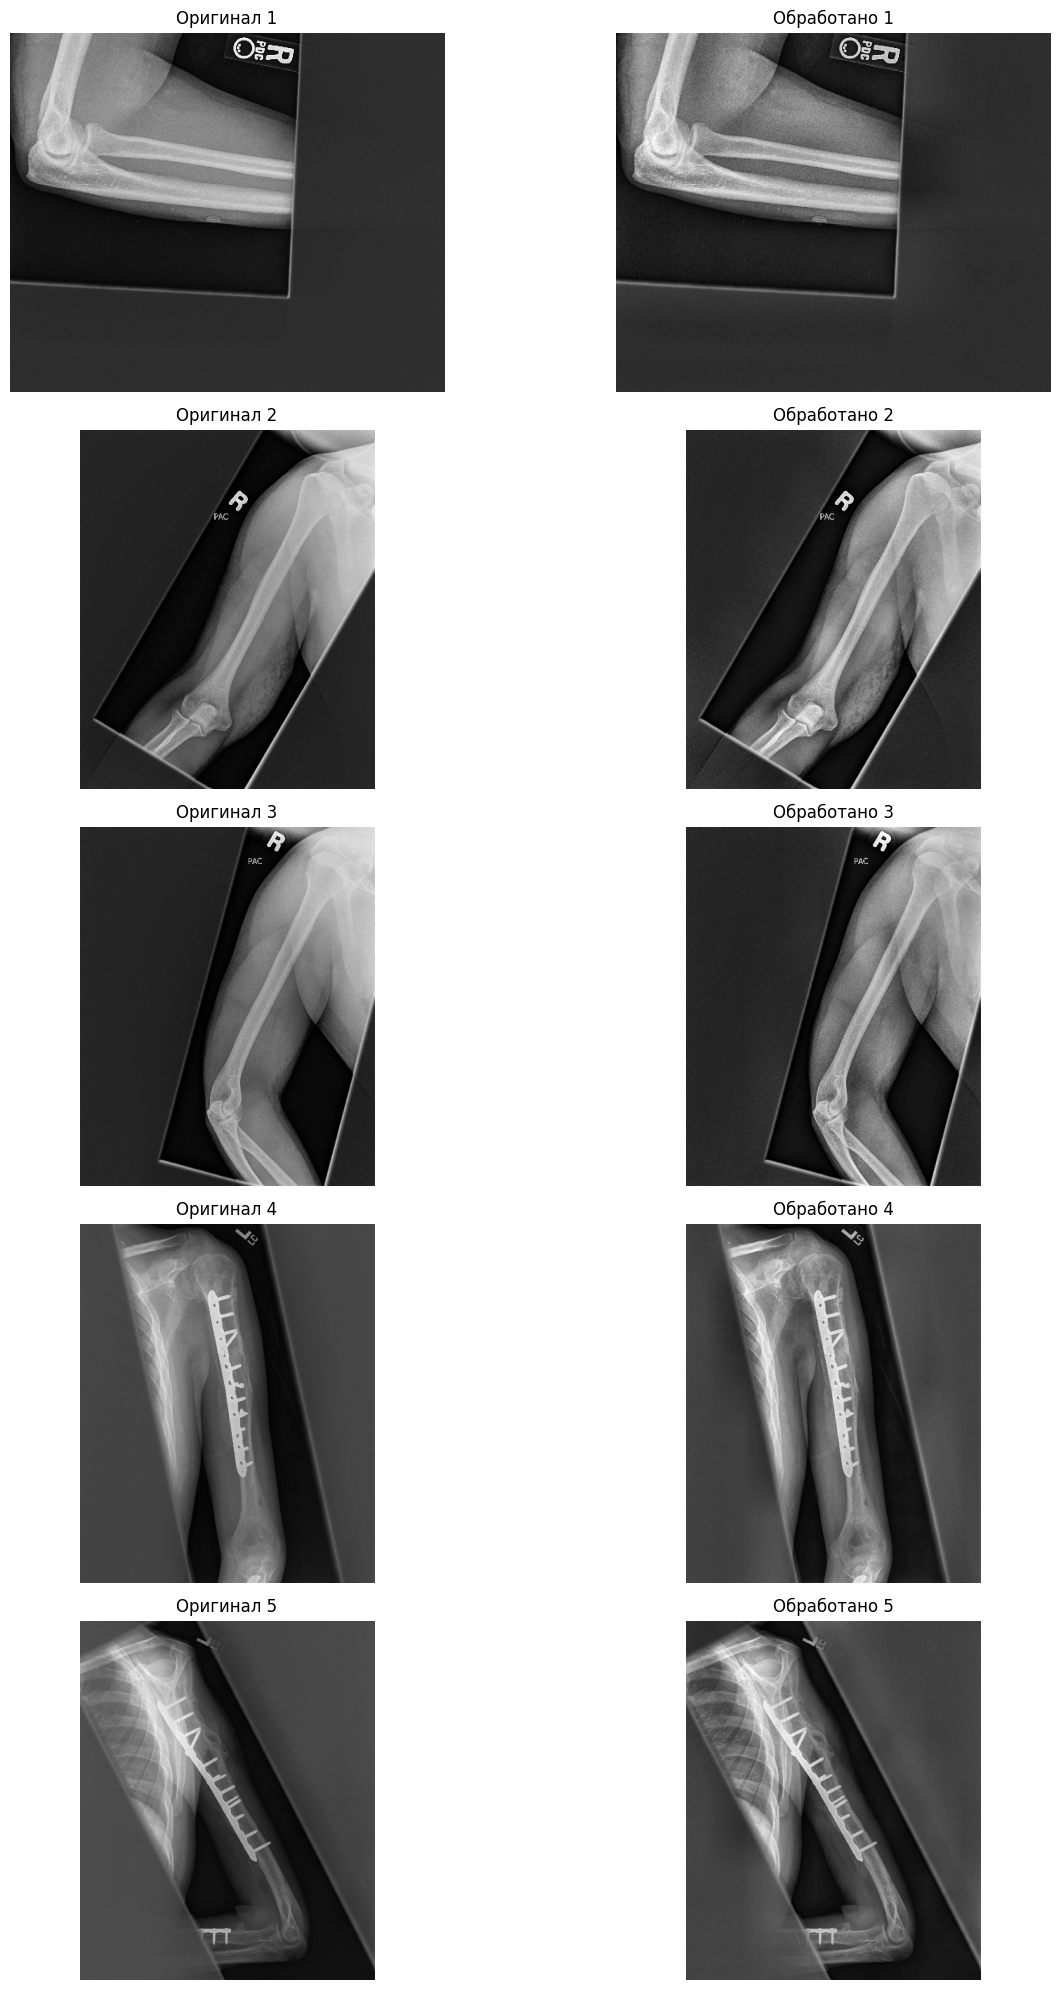

In [7]:
low_contrast_df = brightness_df.sort_values(by='std').head(5)

#выводим примеры изображений до/после
def enhance_comparison(paths, n=5):
    plt.figure(figsize=(14, 4 * n))

    for i, path in enumerate(paths[:n]):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        brightness = np.mean(img)
        contrast = np.std(img)

        alpha, beta, clip_limit = parameters(brightness, contrast)
        tile_grid_size = (8, 8)

        # CLAHE + контраст/яркость
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        img_clahe = clahe.apply(img)
        enhanced = cv2.convertScaleAbs(img_clahe, alpha=alpha, beta=beta)

        # Оригинал
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Оригинал {i+1}')
        plt.axis('off')

        # Обработанное
        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(enhanced, cmap='gray')
        plt.title(f'Обработано {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


enhance_comparison(valid_paths)

#### Невооруженным взглядом можно заметить, что контраст и читаемость изображений улучшились.
#### Проанализируем контрастность и яркость обработанного датасета.

In [8]:
#загружаем обработанный датасет
# датасет
enhanced_image_dir = 'MURA-enhanced'

#Пути к файлам
enhanced_paths = []
for root, dirs, files in os.walk(enhanced_image_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            enhanced_paths.append(os.path.join(root, file))

In [9]:
enhanced_brightness_data = []

for path in tqdm(enhanced_paths, desc='Извлечение статистики яркости после обработки'):
    stats = get_brightness_stats(path)
    if stats:
        enhanced_brightness_data.append({**stats, 'path': path})

enhanced_brightness = pd.DataFrame(enhanced_brightness_data)
print(enhanced_brightness.describe())

Извлечение статистики яркости после обработки: 100%|██████████| 40005/40005 [01:14<00:00, 536.13it/s]

                min           max          mean           std         range
count  40005.000000  40005.000000  40005.000000  40005.000000  40005.000000
mean      18.229921    251.257468     84.626119     42.104639    233.027547
std       11.236937     12.525503     24.413656     11.397228     16.394736
min        0.000000     34.000000     23.003377      0.420841     13.000000
25%       12.000000    255.000000     71.403527     33.951035    232.000000
50%       13.000000    255.000000     80.298916     40.890575    234.000000
75%       23.000000    255.000000     92.198038     49.091548    243.000000
max      135.000000    255.000000    233.250778    105.742145    255.000000


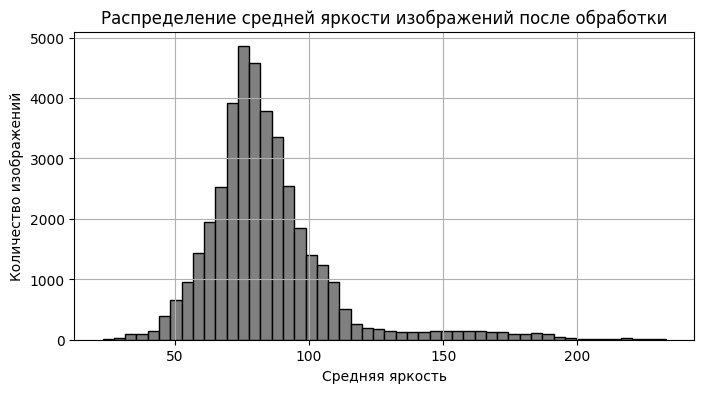

In [10]:
# Гистограмма средней яркости
plt.figure(figsize=(8,4))
plt.hist(enhanced_brightness['mean'], bins=50, color='gray', edgecolor='black')
plt.title('Распределение средней яркости изображений после обработки')
plt.xlabel('Средняя яркость')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

Среднее значение яркости увеличилось, что улучшило визуальное восприятие деталей.

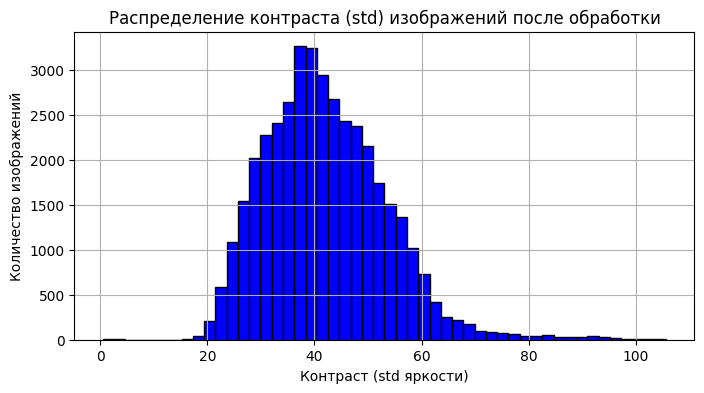

In [11]:
# Гистограмма стандартного отклонения (контраста)
plt.figure(figsize=(8,4))
plt.hist(enhanced_brightness['std'], bins=50, color='blue', edgecolor='black')
plt.title('Распределение контраста (std) изображений после обработки')
plt.xlabel('Контраст (std яркости)')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

 Std вырос, особенно у изображений c совсем низким контрастом. Такое улучшение сделает границы и структуры более различимыми.

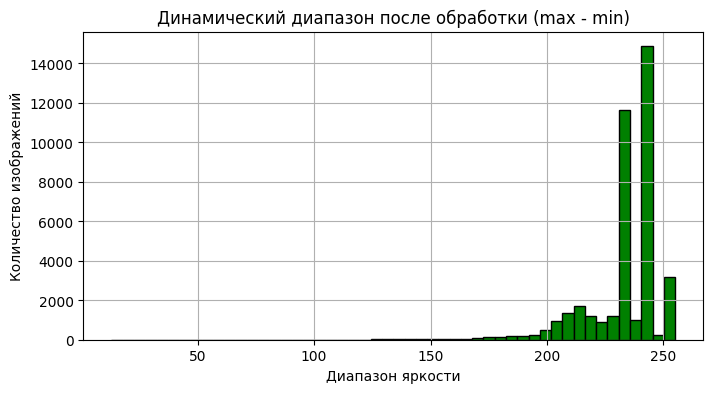

In [12]:
# Гистограмма динамического диапазона (max - min)
plt.figure(figsize=(8,4))
plt.hist(enhanced_brightness['range'], bins=50, color='green', edgecolor='black')
plt.title('Динамический диапазон после обработки (max - min)')
plt.xlabel('Диапазон яркости')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

На графике преобладают значения в диапазоне 230–255. Это говорит о том, что изображения охватывают почти весь возможный спектр яркости, что Отсутствие большого числа с узким диапазоном (ниже 200) — указывает на устранение «плоских» и недоэкспонированных изображений, в сравнении с первоначальными данными.

#### Посмотрим резкость изображений после обработки

In [13]:
#функция определения резкости из EDA
def compute_blur_score(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    return laplacian_var

enhanced_blur_scores = []

for i, row in tqdm(enhanced_brightness.iterrows(), total=len(enhanced_brightness), desc='Извлечение статистики размытия после обработки'):
    score = compute_blur_score(row['path'])
    if score is not None:
        enhanced_blur_scores.append({'path': row['path'], 'blur_var': score})
enhanced_blur_df = pd.DataFrame(enhanced_blur_scores)


Извлечение статистики размытия после обработки: 100%|██████████| 40005/40005 [01:24<00:00, 472.83it/s]


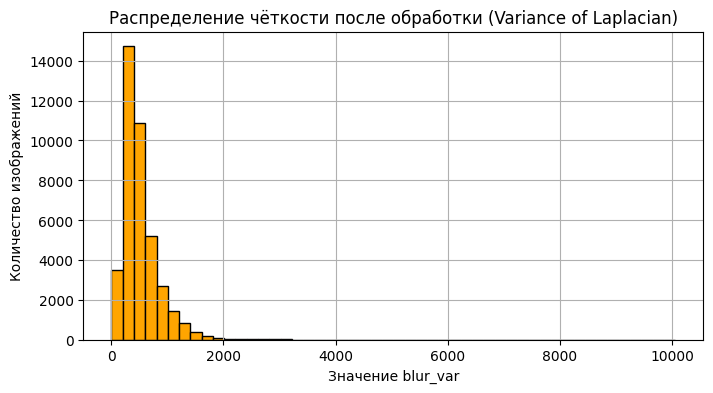

In [14]:
# Визуализация
plt.figure(figsize=(8,4))
plt.hist(enhanced_blur_df['blur_var'], bins=50, color='orange', edgecolor='black')
plt.title("Распределение чёткости после обработки (Variance of Laplacian)")
plt.xlabel("Значение blur_var")
plt.ylabel("Количество изображений")
plt.grid(True)
plt.show()

Распределение blur_var показывает, что большинство изображений имеют достаточную чёткость.

In [15]:
# доля потенциально размытых изображений
num_blurry = (enhanced_blur_df['blur_var'] < 50).sum()
total = len(enhanced_blur_df)
print(f"🔍 Сильно размытых изображений: {num_blurry} из {total} ({num_blurry/total:.2%})")

🔍 Сильно размытых изображений: 13 из 40005 (0.03%)


## Изменения размеров

In [16]:
image_dir = Path("MURA-enhanced")   # корень с исходными картинками
extensions = {".png", ".jpg", ".jpeg"}  # на всякий случай

def collect_image_dimensions(root_dir: Path):
    records = []
    for path in root_dir.rglob("*"):
        if path.suffix.lower() in extensions and not path.name.startswith("._"):
            try:
                with Image.open(path) as img:
                    w, h = img.size
            except Exception as e:
                print(f"⚠️ Ошибка при чтении {path}: {e}")
                continue
            records.append(
                {
                    "path": path,
                    "width": w,
                    "height": h,
                    "aspect_ratio": w / h if h != 0 else np.nan,
                }
            )
    df = pd.DataFrame(records)
    print(f"Всего найдено изображений: {len(df)}")
    return df

df_dimensions = collect_image_dimensions(image_dir)
display(df_dimensions.head())


Всего найдено изображений: 40005


,path,width,height,aspect_ratio
0,MURA-enhanced/train/XR_HAND/patient10502/study...,336,512,0.656250
1,MURA-enhanced/train/XR_HAND/patient10502/study...,336,512,0.656250
2,MURA-enhanced/train/XR_HAND/patient10502/study...,322,512,0.628906
3,MURA-enhanced/train/XR_HAND/patient09246/study...,278,512,0.542969
4,MURA-enhanced/train/XR_HAND/patient09246/study...,316,512,0.617188


In [17]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image, ImageOps

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from IPython.display import display

In [18]:
# Убираем NaN на всякий случай
df_clean = df_dimensions.dropna(subset=["aspect_ratio"]).copy()

X = df_clean[["aspect_ratio"]].values

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init="auto"  # если sklearn>=1.4, иначе можно убрать этот параметр
)

df_clean["ar_cluster"] = kmeans.fit_predict(X)

# Подмешаем обратно в оригинальный df по path
df_dimensions = df_dimensions.merge(
    df_clean[["path", "ar_cluster"]],
    on="path",
    how="left"
)

cluster_stats = (
    df_dimensions
    .groupby("ar_cluster")
    .agg(
        count=("aspect_ratio", "size"),
        mean_ar=("aspect_ratio", "mean"),
        median_ar=("aspect_ratio", "median"),
        std_ar=("aspect_ratio", "std"),
        mean_w=("width", "mean"),
        median_w=("width", "median"),
        std_w=("width", "std"),
        mean_h=("height", "mean"),
        median_h=("height", "median"),
        std_h=("height", "std"),
    )
)
display(cluster_stats)

,count,mean_ar,median_ar,std_ar,mean_w,median_w,std_w,mean_h,median_h,std_h
ar_cluster,,,,,,,,,,
0,7785,1.293487,1.261084,0.247560,512.000000,512.0,0.000000,404.153243,406.0,46.086209
1,23995,0.806505,0.792969,0.077577,412.657512,406.0,38.975324,511.735195,512.0,2.002285
2,8225,0.496859,0.511719,0.102084,254.391733,262.0,52.266841,512.000000,512.0,0.000000


In [19]:
# Размеры, рекомендованные chatgpt как более оптимальные
# TARGET_H = 256
# TARGET_W = 320
TARGET_H = 224
TARGET_W = 224

def resize_with_padding(img: Image.Image,
                        target_h: int = TARGET_H,
                        target_w: int = TARGET_W) -> Image.Image:
    """
    Ресайз изображения с сохранением пропорций + центрированный паддинг
    до (target_h, target_w).
    """
    w, h = img.size

    # Первый шаг: пробуем масштабировать по высоте
    if h > 0:
        scale = target_h / h
    else:
        scale = 1.0

    new_w = int(round(w * scale))
    new_h = int(round(h * scale))

    # Если по высоте всё хорошо, но ширина вдруг слишком большая — масштабируем по ширине
    if new_w > target_w:
        scale = target_w / w
        new_w = int(round(w * scale))
        new_h = int(round(h * scale))

    # Собственно ресайз
    img_resized = img.resize((new_w, new_h), Image.BILINEAR)

    # Паддинг до нужного размера
    pad_left = (target_w - new_w) // 2
    pad_right = target_w - new_w - pad_left
    pad_top = (target_h - new_h) // 2
    pad_bottom = target_h - new_h - pad_top

    # Фон чёрный (0), под рентгены как раз
    img_padded = ImageOps.expand(
        img_resized,
        border=(pad_left, pad_top, pad_right, pad_bottom),
        fill=0
    )

    return img_padded


In [20]:
output_root = Path(f"MURA-v1.1-resized-{TARGET_W}x{TARGET_H}")
output_root.mkdir(parents=True, exist_ok=True)

def save_resized_dataset(df: pd.DataFrame,
                         input_root: Path,
                         output_root: Path):
    num_saved = 0
    for i, row in df.iterrows():
        src_path: Path = row["path"]
        rel_path = src_path.relative_to(input_root)  # относительный путь от корня
        dst_path = output_root / rel_path

        dst_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            with Image.open(src_path) as img:
                img = img.convert("L")  # на всякий случай делаем grayscale
                img_resized = resize_with_padding(img)
                img_resized.save(dst_path)
            num_saved += 1
        except Exception as e:
            print(f"⚠️ Ошибка при обработке {src_path}: {e}")

    print(f"Готово! Сохранено изображений: {num_saved}")

save_resized_dataset(df_dimensions, image_dir, output_root)


Готово! Сохранено изображений: 40005



=== Кластер 0 ===


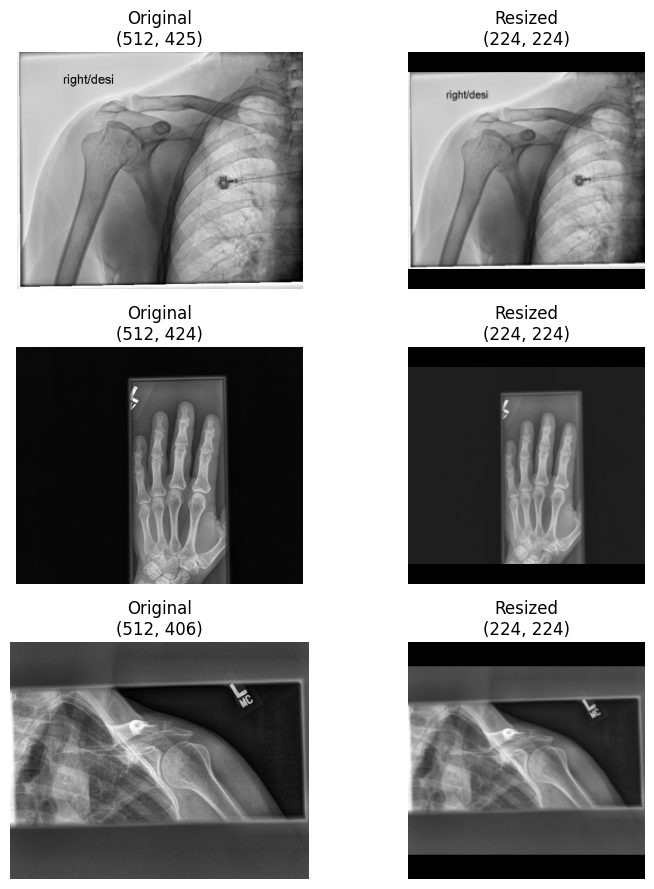


=== Кластер 1 ===


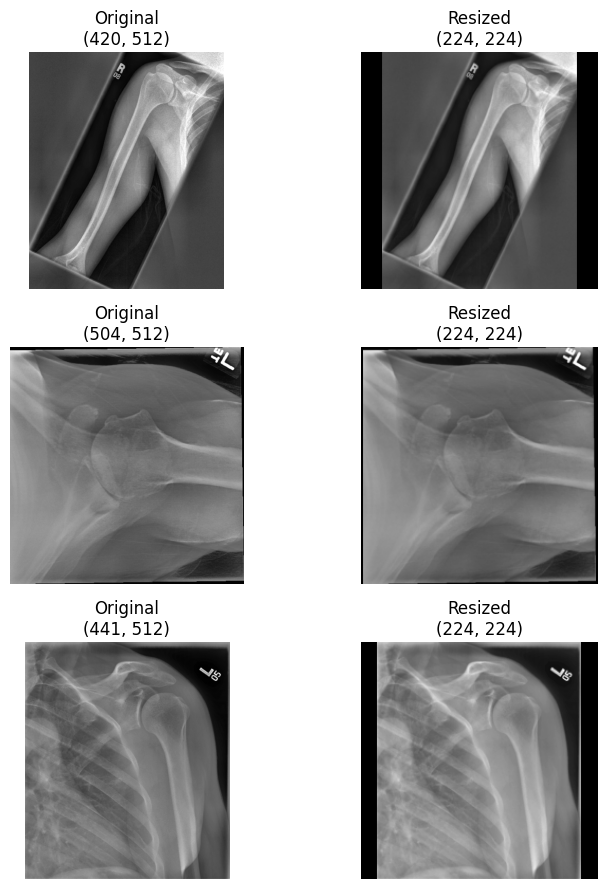


=== Кластер 2 ===


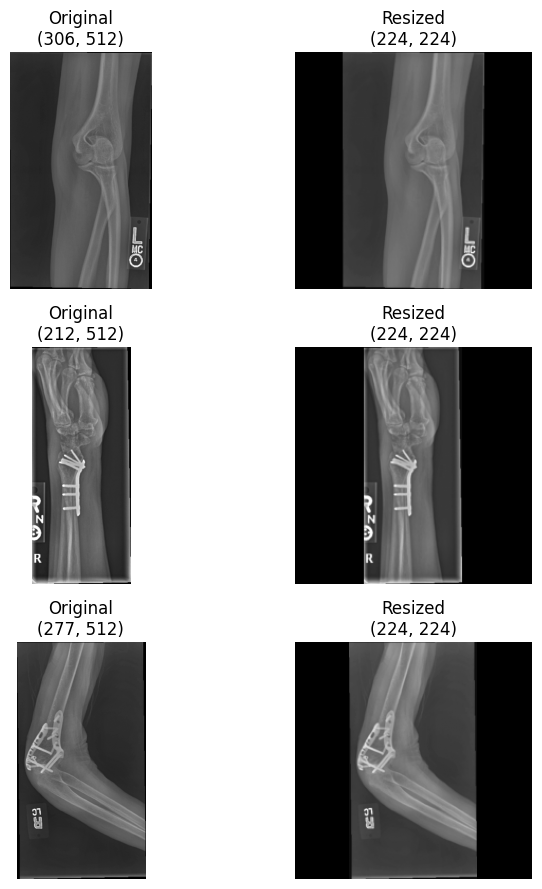

In [22]:
def show_cluster_examples(df: pd.DataFrame,
                          input_root: Path,
                          output_root: Path,
                          samples_per_cluster: int = 3):
    clusters = sorted(df["ar_cluster"].dropna().unique())
    for cl in clusters:
        print(f"\n=== Кластер {cl} ===")
        df_cl = df[df["ar_cluster"] == cl].sample(
            n=min(samples_per_cluster, (df["ar_cluster"] == cl).sum()),
            random_state=42
        )

        fig, axes = plt.subplots(
            nrows=samples_per_cluster,
            ncols=2,
            figsize=(8, 3 * samples_per_cluster)
        )

        if samples_per_cluster == 1:
            axes = np.array([axes])  # чтобы всегда была 2D-матрица

        for row_idx, (_, row) in enumerate(df_cl.iterrows()):
            src_path: Path = row["path"]
            rel_path = src_path.relative_to(input_root)
            dst_path = output_root / rel_path

            # Оригинал
            try:
                with Image.open(src_path) as img_orig:
                    axes[row_idx, 0].imshow(img_orig, cmap="gray")
                    axes[row_idx, 0].set_title(f"Original\n{img_orig.size}")
                    axes[row_idx, 0].axis("off")
            except Exception as e:
                axes[row_idx, 0].set_title(f"Ошибка чтения\n{src_path}")
                axes[row_idx, 0].axis("off")

            # Ресайз
            try:
                with Image.open(dst_path) as img_resized:
                    axes[row_idx, 1].imshow(img_resized, cmap="gray")
                    axes[row_idx, 1].set_title(f"Resized\n{img_resized.size}")
                    axes[row_idx, 1].axis("off")
            except Exception as e:
                axes[row_idx, 1].set_title(f"Нет файла\n{dst_path}")
                axes[row_idx, 1].axis("off")

        plt.tight_layout()
        plt.show()

show_cluster_examples(df_dimensions, image_dir, output_root, samples_per_cluster=3)

# ML Часть

## Линейные модели - LogisticRegression, SGDClassifier, RidgeClassifier

#### Заново создадим датафрейм как в EDA

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from scipy.stats import skew, kurtosis, entropy
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Путь к корневой папке MURA-v1.0
DATA_ROOT = "MURA-v1.1-resized-224x224" 

# Проверка наличия папки
assert os.path.exists(DATA_ROOT), f"Папка {DATA_ROOT} не найдена. Укажите правильный путь."

In [4]:
def parse_study_path(study_path: str):
    """Извлекает метаинформацию из пути к исследованию."""
    parts = Path(study_path).parts
    split = parts[-4]
    anatomy = parts[-3]
    patient_id = parts[-2]
    study_name = parts[-1]
    label = 1 if 'positive' in study_name else 0  # 1 = abnormal, 0 = normal
    return {
        'split': split,
        'anatomy': anatomy,
        'patient_id': patient_id,
        'study_id': study_name,
        'label': label,
        'path': study_path
    }

def build_dataframe(root_dir: str):
    records = []
    for split in ['train', 'valid']:
        split_path = os.path.join(root_dir, split)
        if not os.path.isdir(split_path):
            continue
        for anatomy in os.listdir(split_path):
            anatomy_path = os.path.join(split_path, anatomy)
            if not os.path.isdir(anatomy_path):
                continue
            for patient in os.listdir(anatomy_path):
                patient_path = os.path.join(anatomy_path, patient)
                for study in os.listdir(patient_path):
                    study_path = os.path.join(patient_path, study)
                    if os.path.isdir(study_path):
                        records.append(parse_study_path(study_path))
    return pd.DataFrame(records)

# Сбор данных
df = build_dataframe(DATA_ROOT)
print(f"✅ Загружено {len(df)} исследований от {df['patient_id'].nunique()} пациентов.")

✅ Загружено 14656 исследований от 11967 пациентов.


#### Проверим данные

In [5]:
# Показываем статистику
print(f"Всего изображений: {len(df)}")
print("Распределение меток:")
print(df["label"].value_counts().sort_index().rename({0: "Normal", 1: "Abnormal"}))

# Сохраняем
df.to_csv("mura_preprocessed.csv", index=False)
print("\n✅ CSV сохранён: mura_preprocessed.csv")

Всего изображений: 14656
Распределение меток:
label
Normal      8941
Abnormal    5715
Name: count, dtype: int64

✅ CSV сохранён: mura_preprocessed.csv


#### Обучим модель логистической регрессии и посчитаем метрики

In [32]:

def extract_intensity_features_from_study(study_path):
    # Функция извлечения признаков из папки исследования
    study_dir = Path(study_path)
    image_files = list(study_dir.glob("*.png")) + list(study_dir.glob("*.jpg"))
    if not image_files:
        raise FileNotFoundError(f"Нет изображений в: {study_dir}")
    img_path = image_files[0]  # используем первое изображение
    img = Image.open(img_path).convert('L')
    flat = np.array(img).ravel().astype(np.float32) / 255.0
    return {
        'mean': np.mean(flat),
        'std': np.std(flat),
        'median': np.median(flat),
        'skewness': skew(flat),
        'kurtosis': kurtosis(flat),
        'entropy': entropy(np.histogram(flat, bins=64, density=True)[0] + 1e-8),
        'p90': np.percentile(flat, 90),
        'p10': np.percentile(flat, 10)
    }


# Разделение на train / val
train_df = df[df['split'] == 'train']
val_df = df[df['split'] == 'valid']

# Обработка по анатомиям
results = []

for anatomy in sorted(df['anatomy'].unique()):
    print(f"\nОбработка: {anatomy}")
    
    train_subset = train_df[train_df['anatomy'] == anatomy].copy()
    val_subset = val_df[val_df['anatomy'] == anatomy].copy()
    
    if len(train_subset) < 10 or len(val_subset) < 5:
        print(f"  Пропущено: мало данных (train={len(train_subset)}, val={len(val_subset)})")
        continue

    # Извлечение признаков: train 
    X_train_list, y_train_list = [], []
    for _, row in train_subset.iterrows():
        try:
            feats = extract_intensity_features_from_study(row['path'])
            X_train_list.append(feats)
            y_train_list.append(row['label'])
        except Exception:
            continue
    
    # Извлечение признаков: val
    X_val_list, y_val_list = [], []
    for _, row in val_subset.iterrows():
        try:
            feats = extract_intensity_features_from_study(row['path'])
            X_val_list.append(feats)
            y_val_list.append(row['label'])
        except Exception:
            continue

    if len(X_train_list) == 0 or len(X_val_list) == 0:
        print(f"  Пропущено: не удалось извлечь признаки")
        continue

    # Преобразуем в датафреймы/массивы
    X_train = pd.DataFrame(X_train_list)
    y_train = np.array(y_train_list, dtype=int)
    X_val = pd.DataFrame(X_val_list)
    y_val = np.array(y_val_list, dtype=int)

    # Выравнивание колонок (на случай, если в val не хватает каких-то признаков)
    X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

    # Шкалирование
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Обучение
    model = LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    )
    model.fit(X_train_scaled, y_train)

    # Предсказание на тестовых данных
    y_pred = model.predict(X_val_scaled)

    # Метрики на тестовых данных
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, pos_label=1, zero_division=0)
    kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')

    results.append({
        'Anatomy': anatomy,
        'Train_N': len(X_train_list),
        'Val_N': len(X_val_list),
        'Val_Abnormal': int(np.sum(y_val == 1)),
        'Accuracy': acc,
        'F1_Abnormal': f1,
        'Cohen_Kappa': kappa
    })

    print(f"  Train: {len(X_train_list)}, Val: {len(X_val_list)}, Kappa = {kappa:.3f}")


# Сводная таблица

results_lr = pd.DataFrame(results)
print("ЛИНЕЙНАЯ МОДЕЛЬ (Logistic Regression) — ОЦЕНКА НА ОФИЦИАЛЬНОЙ ВАЛИДАЦИИ")
print("Признаки: статистика интенсивности (1 изображение на исследование)")
print(results_lr.to_string(index=False, float_format="%.3f"))



Обработка: XR_ELBOW
  Train: 1754, Val: 158, Kappa = 0.065

Обработка: XR_FINGER
  Train: 1935, Val: 175, Kappa = 0.359

Обработка: XR_FOREARM
  Train: 877, Val: 133, Kappa = 0.247

Обработка: XR_HAND
  Train: 2018, Val: 167, Kappa = 0.025

Обработка: XR_HUMERUS
  Train: 592, Val: 135, Kappa = 0.274

Обработка: XR_SHOULDER
  Train: 2821, Val: 194, Kappa = 0.299

Обработка: XR_WRIST
  Train: 3460, Val: 237, Kappa = 0.188
ЛИНЕЙНАЯ МОДЕЛЬ (Logistic Regression) — ОЦЕНКА НА ОФИЦИАЛЬНОЙ ВАЛИДАЦИИ
Признаки: статистика интенсивности (1 изображение на исследование)
    Anatomy  Train_N  Val_N  Val_Abnormal  Accuracy  F1_Abnormal  Cohen_Kappa
   XR_ELBOW     1754    158            66     0.532        0.493        0.065
  XR_FINGER     1935    175            83     0.680        0.667        0.359
 XR_FOREARM      877    133            64     0.624        0.609        0.247
    XR_HAND     2018    167            66     0.497        0.481        0.025
 XR_HUMERUS      592    135            67     

#### Обучим модель SGDClassifier и посчитаем метрики

In [49]:

# Обучение SGDClassifier на уже подготовленных данных
results_sgd = []

for anatomy in sorted(df['anatomy'].unique()):
    print(f"\nОбработка: {anatomy}")
    
    train_subset = train_df[train_df['anatomy'] == anatomy].copy()
    val_subset = val_df[val_df['anatomy'] == anatomy].copy()
    
    if len(train_subset) < 10 or len(val_subset) < 5:
        print(f"  Пропущено: мало данных")
        continue

    # Извлечение признаков: train
    X_train_list, y_train_list = [], []
    for _, row in train_subset.iterrows():
        try:
            feats = extract_intensity_features_from_study(row['path'])
            X_train_list.append(feats)
            y_train_list.append(row['label'])
        except Exception:
            continue

    # Извлечение признаков: val
    X_val_list, y_val_list = [], []
    for _, row in val_subset.iterrows():
        try:
            feats = extract_intensity_features_from_study(row['path'])
            X_val_list.append(feats)
            y_val_list.append(row['label'])
        except Exception:
            continue

    if len(X_train_list) == 0 or len(X_val_list) == 0:
        print(f"  Пропущено: не удалось извлечь признаки")
        continue

    # Преобразуем в датафреймы/массивы
    X_train = pd.DataFrame(X_train_list)
    y_train = np.array(y_train_list, dtype=int)
    X_val = pd.DataFrame(X_val_list)
    y_val = np.array(y_val_list, dtype=int)
    X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

    # Шкалирование
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Обучение SGDClassifier
    model = SGDClassifier(loss='log_loss',
                          random_state=42,
                          class_weight='balanced',
                          max_iter=1000)
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    # Метрики
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, pos_label=1, zero_division=0)
    kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')

    results_sgd.append({
        'Anatomy': anatomy,
        'Train_N': len(X_train_list),
        'Val_N': len(X_val_list),
        'Val_Abnormal': int(np.sum(y_val == 1)),
        'Accuracy': acc,
        'F1_Abnormal': f1,
        'Cohen_Kappa': kappa
    })

    print(f"  Train: {len(X_train_list)}, Val: {len(X_val_list)}, Kappa = {kappa:.3f}")


results_sgd_df = pd.DataFrame(results_sgd)

print("SGD CLASSIFIER — ОЦЕНКА НА ОФИЦИАЛЬНОЙ ВАЛИДАЦИИ")
print("Признаки: статистика интенсивности (1 изображение на исследование)")

print(results_sgd_df.to_string(index=False, float_format="%.3f"))


Обработка: XR_ELBOW
  Train: 1754, Val: 158, Kappa = 0.265

Обработка: XR_FINGER
  Train: 1935, Val: 175, Kappa = 0.384

Обработка: XR_FOREARM
  Train: 877, Val: 133, Kappa = -0.029

Обработка: XR_HAND
  Train: 2018, Val: 167, Kappa = -0.011

Обработка: XR_HUMERUS
  Train: 592, Val: 135, Kappa = 0.066

Обработка: XR_SHOULDER
  Train: 2821, Val: 194, Kappa = 0.109

Обработка: XR_WRIST
  Train: 3460, Val: 237, Kappa = 0.043
SGD CLASSIFIER — ОЦЕНКА НА ОФИЦИАЛЬНОЙ ВАЛИДАЦИИ
Признаки: статистика интенсивности (1 изображение на исследование)
    Anatomy  Train_N  Val_N  Val_Abnormal  Accuracy  F1_Abnormal  Cohen_Kappa
   XR_ELBOW     1754    158            66     0.614        0.639        0.265
  XR_FINGER     1935    175            83     0.691        0.690        0.384
 XR_FOREARM      877    133            64     0.481        0.524       -0.029
    XR_HAND     2018    167            66     0.509        0.406       -0.011
 XR_HUMERUS      592    135            67     0.533        0.496   

#### Обучим модель RidgeClassifier и посчитаем метрики

In [50]:

# Обработка по анатомиям (RidgeClassifier)
results_ridge = []

for anatomy in sorted(df['anatomy'].unique()):
    print(f"\nОбработка: {anatomy}")
    
    train_subset = train_df[train_df['anatomy'] == anatomy].copy()
    val_subset = val_df[val_df['anatomy'] == anatomy].copy()
    
    if len(train_subset) < 10 or len(val_subset) < 5:
        print(f"  Пропущено: мало данных")
        continue

    # Извлечение признаков: train
    X_train_list, y_train_list = [], []
    for _, row in train_subset.iterrows():
        try:
            feats = extract_intensity_features_from_study(row['path'])
            X_train_list.append(feats)
            y_train_list.append(row['label'])
        except Exception:
            continue

    # Извлечение признаков: val
    X_val_list, y_val_list = [], []
    for _, row in val_subset.iterrows():
        try:
            feats = extract_intensity_features_from_study(row['path'])
            X_val_list.append(feats)
            y_val_list.append(row['label'])
        except Exception:
            continue

    if len(X_train_list) == 0 or len(X_val_list) == 0:
        print(f"  Пропущено: не удалось извлечь признаки")
        continue
     
     # Преобразуем в датафреймы/массивы
    X_train = pd.DataFrame(X_train_list)
    y_train = np.array(y_train_list, dtype=int)
    X_val = pd.DataFrame(X_val_list)
    y_val = np.array(y_val_list, dtype=int)
    X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

    # Шкалирование
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Обучение RidgeClassifier
    model = RidgeClassifier(
        random_state=42,
        class_weight='balanced'
    )
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    # Метрики
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, pos_label=1, zero_division=0)
    kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')

    results_ridge.append({
        'Anatomy': anatomy,
        'Train_N': len(X_train_list),
        'Val_N': len(X_val_list),
        'Val_Abnormal': int(np.sum(y_val == 1)),
        'Accuracy': acc,
        'F1_Abnormal': f1,
        'Cohen_Kappa': kappa
    })

    print(f"  Train: {len(X_train_list)}, Val: {len(X_val_list)}, Kappa = {kappa:.3f}")

# Сводная таблица

results_ridge_df = pd.DataFrame(results_ridge)

print("RIDGE CLASSIFIER — ОЦЕНКА НА ОФИЦИАЛЬНОЙ ВАЛИДАЦИИ")
print("Признаки: статистика интенсивности (1 изображение на исследование)")

print(results_ridge_df.to_string(index=False, float_format="%.3f"))


Обработка: XR_ELBOW
  Train: 1754, Val: 158, Kappa = 0.173

Обработка: XR_FINGER
  Train: 1935, Val: 175, Kappa = 0.404

Обработка: XR_FOREARM
  Train: 877, Val: 133, Kappa = 0.200

Обработка: XR_HAND
  Train: 2018, Val: 167, Kappa = 0.114

Обработка: XR_HUMERUS
  Train: 592, Val: 135, Kappa = 0.333

Обработка: XR_SHOULDER
  Train: 2821, Val: 194, Kappa = 0.085

Обработка: XR_WRIST
  Train: 3460, Val: 237, Kappa = 0.163
RIDGE CLASSIFIER — ОЦЕНКА НА ОФИЦИАЛЬНОЙ ВАЛИДАЦИИ
Признаки: статистика интенсивности (1 изображение на исследование)
    Anatomy  Train_N  Val_N  Val_Abnormal  Accuracy  F1_Abnormal  Cohen_Kappa
   XR_ELBOW     1754    158            66     0.576        0.573        0.173
  XR_FINGER     1935    175            83     0.703        0.687        0.404
 XR_FOREARM      877    133            64     0.602        0.569        0.200
    XR_HAND     2018    167            66     0.551        0.516        0.114
 XR_HUMERUS      592    135            67     0.667        0.667   

#### Сведем все данные в одну таблицу

In [51]:
# Объединяем все результаты в одну таблицу
comparison_df = results_lr[['Anatomy', 'Cohen_Kappa']].copy()
comparison_df.rename(columns={'Cohen_Kappa': 'LogisticRegression'}, inplace=True)

comparison_df['RidgeClassifier'] = results_ridge_df['Cohen_Kappa'].values
comparison_df['SGDClassifier'] = results_sgd_df['Cohen_Kappa'].values

# Добавляем среднее
comparison_df['Mean_Kappa'] = comparison_df[['LogisticRegression', 'RidgeClassifier', 'SGDClassifier']].mean(axis=1)

# Сортируем
comparison_df = comparison_df.sort_values('Mean_Kappa', ascending=False)


print("СРАВНЕНИЕ ЛИНЕЙНЫХ МОДЕЛЕЙ")
print("Признаки: статистика интенсивности (1 изображение на исследование)")
print(comparison_df.to_string(index=False, float_format="%.3f"))

# Вывод среднего Kappa по моделям
avg_kappa_lr  = comparison_df['LogisticRegression'].mean()
avg_kappa_ridge = comparison_df['RidgeClassifier'].mean()
avg_kappa_sgd = comparison_df['SGDClassifier'].mean()


print("СРЕДНИЙ KAPPA ПО МОДЕЛЯМ:")

print(f"LogisticRegression: {avg_kappa_lr:.3f}")
print(f"RidgeClassifier:    {avg_kappa_ridge:.3f}")
print(f"SGDClassifier:      {avg_kappa_sgd:.3f}")


СРАВНЕНИЕ ЛИНЕЙНЫХ МОДЕЛЕЙ
Признаки: статистика интенсивности (1 изображение на исследование)
    Anatomy  LogisticRegression  RidgeClassifier  SGDClassifier  Mean_Kappa
  XR_FINGER               0.415            0.404          0.384       0.401
 XR_HUMERUS               0.348            0.333          0.066       0.249
   XR_ELBOW               0.183            0.173          0.265       0.207
   XR_WRIST               0.151            0.163          0.043       0.119
 XR_FOREARM               0.168            0.200         -0.029       0.113
XR_SHOULDER               0.064            0.085          0.109       0.086
    XR_HAND               0.081            0.114         -0.011       0.061
СРЕДНИЙ KAPPA ПО МОДЕЛЯМ:
LogisticRegression: 0.202
RidgeClassifier:    0.210
SGDClassifier:      0.118


#### Построим тепловую карту

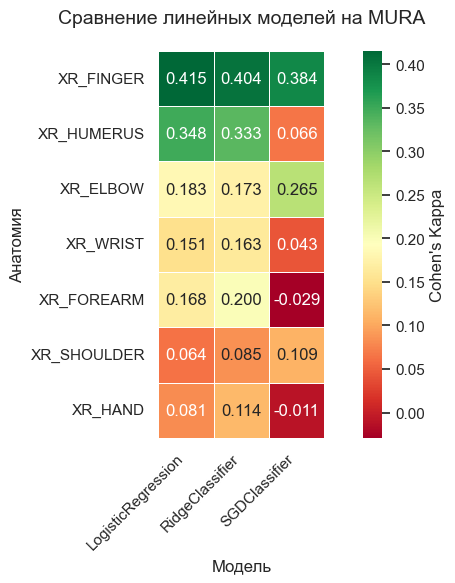

In [53]:
heatmap_data = comparison_df.set_index('Anatomy')[['LogisticRegression', 'RidgeClassifier', 'SGDClassifier']]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",           
    cbar_kws={'label': 'Cohen\'s Kappa'},
    linewidths=0.5,
    square=True
)


plt.title("Сравнение линейных моделей на MURA", fontsize=14, pad=20)
plt.xlabel("Модель", fontsize=12)
plt.ylabel("Анатомия", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

### Предварительные  результаты

Тут нужно будет написать отчет по предобработке и обучению моделей. Про шикарное изменение резкости и улчшение параметров изображения Про классное приведение все к одному размеру. Про то что, для дяльнейшего обучения можно:
* сделать усреднение по всем исследованиям, а не только по одному изображению
* нагенерить дополнительные фичи вида (надписи на рентгенах, импланты)
* поподбирать гиперпараметры
* применить новые модели - случайный лес, ансамблевые методы, HOG
* Про то что лучше всего себя показал RidgeClassifier из-за регуляризации
* метрики и должны быть такими низкими, потому что эта задача не для классичеких моделей. Потом перейдем к CNN

## SVM

### hog + linear svm

In [25]:
# ! pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 28.6 MB/s  0:00:008.6 MB/s eta 0:00:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-image]0m 3/4 [scikit-image]


In [6]:
df

,split,anatomy,patient_id,study_id,label,path
0,train,XR_HUMERUS,patient03222,study1_negative,0,MURA-v1.1-resized-224x224/train/XR_HUMERUS/pat...
1,train,XR_HUMERUS,patient03093,study1_negative,0,MURA-v1.1-resized-224x224/train/XR_HUMERUS/pat...
2,train,XR_HUMERUS,patient02842,study1_positive,1,MURA-v1.1-resized-224x224/train/XR_HUMERUS/pat...
3,train,XR_HUMERUS,patient03027,study1_negative,0,MURA-v1.1-resized-224x224/train/XR_HUMERUS/pat...
4,train,XR_HUMERUS,patient02717,study1_positive,1,MURA-v1.1-resized-224x224/train/XR_HUMERUS/pat...
...,...,...,...,...,...,...
14651,valid,XR_HAND,patient11527,study1_positive,1,MURA-v1.1-resized-224x224/valid/XR_HAND/patien...
14652,valid,XR_HAND,patient11553,study1_negative,0,MURA-v1.1-resized-224x224/valid/XR_HAND/patien...
14653,valid,XR_HAND,patient11578,study1_negative,0,MURA-v1.1-resized-224x224/valid/XR_HAND/patien...
14654,valid,XR_HAND,patient11389,study1_positive,1,MURA-v1.1-resized-224x224/valid/XR_HAND/patien...


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from skimage.feature import hog
import glob
from ml import load_model_data, save_model_data, print_metrics
from sklearn.svm import LinearSVC
from skimage import io
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class ImageLoader(BaseEstimator, TransformerMixin):
    def __init__(self, as_gray=True):
        self.as_gray = as_gray

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X — это массив путей (список строк)
        imgs = [
            print(path) or io.imread(path, as_gray=self.as_gray)
            for path in X
        ]
        return np.array(imgs)

class StudyHOGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, as_gray=True):
        self.as_gray = as_gray

    def fit(self, X, y=None):
        return self

    def _hog_for_image(self, img):
        return hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys'
        )

    def transform(self, X):
        # X — это массив путей к study-папкам
        feats = []
        for study_dir in X:
            img_paths = glob.glob(os.path.join(study_dir, "*.png"))
            hog_vecs = []
            for p in img_paths:
                img = io.imread(p, as_gray=self.as_gray)
                hog_vecs.append(self._hog_for_image(img))
            if len(hog_vecs) == 0:
                # на всякий случай, если папка пустая
                raise ValueError(f"No images in {study_dir}")
            # агрегация: среднее HOG по всем изображениям в study
            study_feat = np.mean(hog_vecs, axis=0)
            feats.append(study_feat)
        return np.vstack(feats)

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class HOGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([
            hog(img, orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys')
            for img in X
        ])
df_train = df[df['split'] == 'train']
df_val = df[df['split'] == 'valid']
X_train = df_train['path'].values
X_val = df_val['path'].values
y_train = df_train['label'].values
y_val = df_val['label'].values
if (pipe := load_model_data('hog_svc_model_all.pkl')) is None:
    pipe = Pipeline([
        # ("image_loader", ImageLoader()),
        # ("hog", HOGTransformer()),
        ("study_hog", StudyHOGTransformer()),
        ("clf", LinearSVC())
    ])
    print("Нет сохранённой модели, обучаем заново...")
    pipe.fit(X_train, y_train)
    save_model_data(pipe, 'hog_svc_model_all.pkl')
if not (saved_inference := load_model_data('hog_svc_preds_all.pkl')):
    print("Нет сохранённого вывода модели, проводим инференс заново...")
    y_pred_train = pipe.predict(X_train)
    y_pred_val = pipe.predict(X_val)
    save_model_data((y_pred_train, y_pred_val), 'hog_svc_preds_all.pkl')
else:
    (y_pred_train, y_pred_val) = saved_inference
print_metrics(y_train, y_pred_train, y_val, y_pred_val);

# pipe = Pipeline([
#     ("pca", PCA(n_components=300)),
#     ("clf", SVC(kernel="rbf"))
# ])

TRAIN METRICS: Accuracy=1.000, F1_Abnormal=1.000, Cohen_Kappa=1.000
VALID METRICS: Accuracy=0.589, F1_Abnormal=0.521, Cohen_Kappa=0.162


kappa просто ужасная на наивном hog + svm (C=1, модель переобучилась)

### Посчитаем HOG один раз для всех и сохраним:

In [6]:
import numpy as np
%load_ext autoreload
%autoreload 2
import importlib
from ml import compute_study_hog
import ml
importlib.reload(ml)

def get_anatomy_filename(anatomy):
    return f"hog_{anatomy}.npz"

for anatomy in df['anatomy'].unique():
    print("\nОбработка анатомии:", anatomy)
    hog_fname = get_anatomy_filename(anatomy)
    try:
        data = np.load(hog_fname, allow_pickle=True)
    except FileNotFoundError:
        X_all, y_all, study_ids, splits, anatomies = compute_study_hog(df[df['anatomy'] == anatomy])
        np.savez(hog_fname, X=X_all, y=y_all, study_ids=study_ids, splits=splits, anatomy=anatomies)


Обработка анатомии: XR_HUMERUS

Обработка анатомии: XR_WRIST

Обработка анатомии: XR_ELBOW

Обработка анатомии: XR_FINGER

Обработка анатомии: XR_SHOULDER

Обработка анатомии: XR_FOREARM

Обработка анатомии: XR_HAND


In [7]:

from sklearn.pipeline import Pipeline
import importlib
# from sklearn.svm import SVC
# from sklearn.decomposition import PCA
from ml import load_model_data, save_model_data, print_metrics
from ml import StudyHOGTransformer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, cohen_kappa_score
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')


resulting_data = {
    'anatomy': [],
    'train_kappa': [],
    'valid_kappa': [],
    'train_accuracy': [],
    'valid_accuracy': [],
    'train_f1': [],
    'valid_f1': [],
    'param_C': []
}
for body_part in df['anatomy'].unique():
    print("\nОбработка анатомии:", body_part)
    # df_train_bodypart= df_train[(df_train['anatomy'] == body_part) & (df_train['split']=='train')]
    # df_test_bodypart= df_val[(df_val['anatomy'] == body_part) & (df_val['split']=='valid')]
    # X_train_bodypart = df_train_bodypart['path'].values
    # y_train_bodypart = df_train_bodypart['label'].values
    # X_test_bodypart_val = df_test_bodypart['path'].values
    # y_test_bodypart_val = df_test_bodypart['label'].values
    data = np.load(get_anatomy_filename(body_part), allow_pickle=True)
    X = data["X"]
    y = data["y"]
    split= data["splits"]
    anatomy = data["anatomy"]
    study_ids = data["study_ids"]
    X_train = X[split == 'train']
    y_train = y[split == 'train']
    X_val = X[split == 'valid']
    y_val = y[split == 'valid']
    if not(grid := load_model_data(f'hog_study_svc_model_{body_part}.pkl')):
        print(f"Нет сохранённой модели для {body_part}, обучаем заново...")

        pipe_bodypart = Pipeline([
            # ("image_loader", ImageLoader()),
            # ("hog", HOGTransformer()),
            # ("study_hog", StudyHOGTransformer()),
            ("clf", LinearSVC())
        ])
        param_grid = {
            "clf__C": [1.0, 0.3, 0.1, 0.03, 0.01, 0.05, 0.025, 0.015, 0.008, 0.003, 0.001]
        }
        grid = GridSearchCV(
            pipe_bodypart,
            param_grid=param_grid,
            scoring=kappa_scorer,
            cv=4,
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train, y_train)
        save_model_data(grid, f"hog_study_svc_model_{body_part}.pkl")
    if not (saved_inference_bodypart := load_model_data(f'hog_study_svc_preds_{body_part}.pkl')):
        print(f"Нет сохранённого вывода модели для {body_part}, проводим инференс заново...")
        y_pred_bodypart_train = grid.best_estimator_.predict(X_train)
        y_pred_bodypart_val = grid.best_estimator_.predict(X_val)
        save_model_data((y_pred_bodypart_train, y_pred_bodypart_val), f"hog_study_svc_preds_{body_part}.pkl")
        saved_inference_bodypart = (y_pred_bodypart_train, y_pred_bodypart_val)
    print(f"Метрики для анатомии: {body_part}")
    y_pred_bodypart_train, y_pred_bodypart_val = saved_inference_bodypart
    resulting_data_anatomy = print_metrics(
        y_train,
        y_pred_bodypart_train,
        y_val,
        y_pred_bodypart_val)
    resulting_data['anatomy'].append(body_part)
    for split in ['train', 'valid']:
        resulting_data[f'{split}_kappa'].append(resulting_data_anatomy[split]['kappa'])
        resulting_data[f'{split}_accuracy'].append(resulting_data_anatomy[split]['accuracy'])
        resulting_data[f'{split}_f1'].append(resulting_data_anatomy[split]['f1'])
    resulting_data['param_C'].append(grid.best_params_['clf__C'])
    display(grid)


# pipe = Pipeline([
#     ("pca", PCA(n_components=300)),
#     ("clf", SVC(kernel="rbf"))
# ])


Обработка анатомии: XR_HUMERUS
Метрики для анатомии: XR_HUMERUS
TRAIN METRICS: Accuracy=0.860, F1_Abnormal=0.839, Cohen_Kappa=0.715
VALID METRICS: Accuracy=0.689, F1_Abnormal=0.672, Cohen_Kappa=0.377


,estimator,Pipeline(step...LinearSVC())])
,param_grid,"{'clf__C': [1.0, 0.3, ...]}"
,scoring,make_scorer(c...hts=quadratic)
,n_jobs,-1
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'



Обработка анатомии: XR_WRIST
File hog_study_svc_model_XR_WRIST.pkl not found.
Нет сохранённой модели для XR_WRIST, обучаем заново...
Fitting 4 folds for each of 11 candidates, totalling 44 fits
File hog_study_svc_preds_XR_WRIST.pkl not found.
Нет сохранённого вывода модели для XR_WRIST, проводим инференс заново...
Метрики для анатомии: XR_WRIST
TRAIN METRICS: Accuracy=0.876, F1_Abnormal=0.833, Cohen_Kappa=0.734
VALID METRICS: Accuracy=0.781, F1_Abnormal=0.694, Cohen_Kappa=0.528


,estimator,Pipeline(step...LinearSVC())])
,param_grid,"{'clf__C': [1.0, 0.3, ...]}"
,scoring,make_scorer(c...hts=quadratic)
,n_jobs,-1
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'



Обработка анатомии: XR_ELBOW
File hog_study_svc_model_XR_ELBOW.pkl not found.
Нет сохранённой модели для XR_ELBOW, обучаем заново...
Fitting 4 folds for each of 11 candidates, totalling 44 fits
File hog_study_svc_preds_XR_ELBOW.pkl not found.
Нет сохранённого вывода модели для XR_ELBOW, проводим инференс заново...
Метрики для анатомии: XR_ELBOW
TRAIN METRICS: Accuracy=0.977, F1_Abnormal=0.968, Cohen_Kappa=0.950
VALID METRICS: Accuracy=0.614, F1_Abnormal=0.527, Cohen_Kappa=0.201


,estimator,Pipeline(step...LinearSVC())])
,param_grid,"{'clf__C': [1.0, 0.3, ...]}"
,scoring,make_scorer(c...hts=quadratic)
,n_jobs,-1
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'



Обработка анатомии: XR_FINGER
File hog_study_svc_model_XR_FINGER.pkl not found.
Нет сохранённой модели для XR_FINGER, обучаем заново...
Fitting 4 folds for each of 11 candidates, totalling 44 fits
File hog_study_svc_preds_XR_FINGER.pkl not found.
Нет сохранённого вывода модели для XR_FINGER, проводим инференс заново...
Метрики для анатомии: XR_FINGER
TRAIN METRICS: Accuracy=0.896, F1_Abnormal=0.848, Cohen_Kappa=0.769
VALID METRICS: Accuracy=0.749, F1_Abnormal=0.707, Cohen_Kappa=0.491


,estimator,Pipeline(step...LinearSVC())])
,param_grid,"{'clf__C': [1.0, 0.3, ...]}"
,scoring,make_scorer(c...hts=quadratic)
,n_jobs,-1
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'



Обработка анатомии: XR_SHOULDER
File hog_study_svc_model_XR_SHOULDER.pkl not found.
Нет сохранённой модели для XR_SHOULDER, обучаем заново...
Fitting 4 folds for each of 11 candidates, totalling 44 fits
File hog_study_svc_preds_XR_SHOULDER.pkl not found.
Нет сохранённого вывода модели для XR_SHOULDER, проводим инференс заново...
Метрики для анатомии: XR_SHOULDER
TRAIN METRICS: Accuracy=0.901, F1_Abnormal=0.903, Cohen_Kappa=0.801
VALID METRICS: Accuracy=0.665, F1_Abnormal=0.652, Cohen_Kappa=0.329


,estimator,Pipeline(step...LinearSVC())])
,param_grid,"{'clf__C': [1.0, 0.3, ...]}"
,scoring,make_scorer(c...hts=quadratic)
,n_jobs,-1
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'



Обработка анатомии: XR_FOREARM
File hog_study_svc_model_XR_FOREARM.pkl not found.
Нет сохранённой модели для XR_FOREARM, обучаем заново...
Fitting 4 folds for each of 11 candidates, totalling 44 fits
File hog_study_svc_preds_XR_FOREARM.pkl not found.
Нет сохранённого вывода модели для XR_FOREARM, проводим инференс заново...
Метрики для анатомии: XR_FOREARM
TRAIN METRICS: Accuracy=0.989, F1_Abnormal=0.983, Cohen_Kappa=0.974
VALID METRICS: Accuracy=0.594, F1_Abnormal=0.500, Cohen_Kappa=0.178


,estimator,Pipeline(step...LinearSVC())])
,param_grid,"{'clf__C': [1.0, 0.3, ...]}"
,scoring,make_scorer(c...hts=quadratic)
,n_jobs,-1
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'



Обработка анатомии: XR_HAND
File hog_study_svc_model_XR_HAND.pkl not found.
Нет сохранённой модели для XR_HAND, обучаем заново...
Fitting 4 folds for each of 11 candidates, totalling 44 fits
File hog_study_svc_preds_XR_HAND.pkl not found.
Нет сохранённого вывода модели для XR_HAND, проводим инференс заново...
Метрики для анатомии: XR_HAND
TRAIN METRICS: Accuracy=1.000, F1_Abnormal=1.000, Cohen_Kappa=1.000
VALID METRICS: Accuracy=0.623, F1_Abnormal=0.452, Cohen_Kappa=0.174


,estimator,Pipeline(step...LinearSVC())])
,param_grid,"{'clf__C': [1.0, 0.3, ...]}"
,scoring,make_scorer(c...hts=quadratic)
,n_jobs,-1
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [ ]:

from sklearn.pipeline import Pipeline
import importlib
# from sklearn.svm import SVC
# from sklearn.decomposition import PCA
from ml import load_model_data, save_model_data, print_metrics
from ml import StudyHOGTransformer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, cohen_kappa_score
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')


resulting_data = {
    'anatomy': [],
    'train_kappa': [],
    'valid_kappa': [],
    'train_accuracy': [],
    'valid_accuracy': [],
    'train_f1': [],
    'valid_f1': [],
    'param_C': []
}
for body_part in df['anatomy'].unique():
    print("\nОбработка анатомии:", body_part)
    # df_train_bodypart= df_train[(df_train['anatomy'] == body_part) & (df_train['split']=='train')]
    # df_test_bodypart= df_val[(df_val['anatomy'] == body_part) & (df_val['split']=='valid')]
    # X_train_bodypart = df_train_bodypart['path'].values
    # y_train_bodypart = df_train_bodypart['label'].values
    # X_test_bodypart_val = df_test_bodypart['path'].values
    # y_test_bodypart_val = df_test_bodypart['label'].values
    data = np.load(get_anatomy_filename(body_part), allow_pickle=True)
    X = data["X"]
    y = data["y"]
    split= data["splits"]
    anatomy = data["anatomy"]
    study_ids = data["study_ids"]
    X_train = X[split == 'train']
    y_train = y[split == 'train']
    X_val = X[split == 'valid']
    y_val = y[split == 'valid']
    if not(grid := load_model_data(f'hog_study_svc_model_{body_part}.pkl')):
        print(f"Нет сохранённой модели для {body_part}, обучаем заново...")

        pipe_bodypart = Pipeline([
            # ("image_loader", ImageLoader()),
            # ("hog", HOGTransformer()),
            # ("study_hog", StudyHOGTransformer()),
            ("clf", LinearSVC())
        ])
        param_grid = {
            "clf__C": [1.0, 0.3, 0.1, 0.03, 0.01, 0.05, 0.025, 0.015, 0.008, 0.003, 0.001]
        }
        grid = GridSearchCV(
            pipe_bodypart,
            param_grid=param_grid,
            scoring=kappa_scorer,
            cv=4,
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train, y_train)
        save_model_data(grid, f"hog_study_svc_model_{body_part}.pkl")
    if not (saved_inference_bodypart := load_model_data(f'hog_study_svc_preds_{body_part}.pkl')):
        print(f"Нет сохранённого вывода модели для {body_part}, проводим инференс заново...")
        y_pred_bodypart_train = grid.best_estimator_.predict(X_train)
        y_pred_bodypart_val = grid.best_estimator_.predict(X_val)
        save_model_data((y_pred_bodypart_train, y_pred_bodypart_val), f"hog_study_svc_preds_{body_part}.pkl")
        saved_inference_bodypart = (y_pred_bodypart_train, y_pred_bodypart_val)
    print(f"Метрики для анатомии: {body_part}")
    y_pred_bodypart_train, y_pred_bodypart_val = saved_inference_bodypart
    resulting_data_anatomy = print_metrics(
        y_train,
        y_pred_bodypart_train,
        y_val,
        y_pred_bodypart_val)
    resulting_data['anatomy'].append(body_part)
    for split in ['train', 'valid']:
        resulting_data[f'{split}_kappa'].append(resulting_data_anatomy[split]['kappa'])
        resulting_data[f'{split}_accuracy'].append(resulting_data_anatomy[split]['accuracy'])
        resulting_data[f'{split}_f1'].append(resulting_data_anatomy[split]['f1'])
    resulting_data['param_C'].append(grid.best_params_['clf__C'])
    display(grid)


# pipe = Pipeline([
#     ("pca", PCA(n_components=300)),
#     ("clf", SVC(kernel="rbf"))
# ])

In [23]:
grid

,steps,"[('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True


In [ ]:
y_pred_val_wrist = pipe_bodypart.predict(df_test_wrist['path'].values)
print_metrics(y_train_wrist, y_pred_wrist, df_test_wrist['label'].values, y_pred_val_wrist)

TRAIN METRICS: Accuracy=1.000, F1_Abnormal=1.000, Cohen_Kappa=1.000
VALID METRICS: Accuracy=0.738, F1_Abnormal=0.663, Cohen_Kappa=0.450


In [39]:
import ml
print(ml.__file__)
print(dir(ml))
# print([name for name in dir(ml) if "HOG" in name or "Study" in name])

/home/rubar01/Course 1/Project/Project2025/ml.py
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'accuracy_score', 'cohen_kappa_score', 'f1_score', 'load_model_data', 'pickle', 'print_metrics', 'save_model_data']
